In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional


df = pd.read_csv("train.csv")

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# X, y 데이터 분
X = df.drop(columns=['Churn', 'customerID']).values
y = df['Churn'].values
y = y.reshape(-1, 1)
X.shape, y.shape

# 데이터 train, test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=0)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

trainset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
testset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=128)
len(train_loader), len(test_loader)

(44, 12)

In [23]:
import os
os.makedirs("module", exist_ok=True)

In [24]:
%%writefile module/train.py

from sklearn.metrics import f1_score
import time
import torch

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_steps
        test_accuracy /= size
    return test_loss, test_accuracy
    
def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_steps
        test_accuracy /= size 
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    [parameter]
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: binary
    [return]
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()
    size = len(dataloader.dataset) 

    all_preds = []  
    all_targets = []  
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if mode == "binary":
            pred_label = (pred >= 0.5).type(torch.int32) 
        else:
            pred_label = torch.argmax(pred, axis=-1)

        all_preds.extend(pred_label.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    f1 = f1_score(all_targets, all_preds, average="binary" if mode == "binary" else "macro")
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy, f1


def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, save_model_path=None, early_stopping=True, patience=10, device='cpu', mode='binary'):
   
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []

    best_epoch = 0
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    best_f1 = 0.0
    
    if save_best_model:
        best_score_save = float('inf')

    if early_stopping:
        trigger_count = 0
        best_score_es = float('inf')
    
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        train_loss, train_accuracy, f1 = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
        
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)

        ## 제일좋은 epoch이면 저장.
        if val_loss < best_val_loss: 
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy
            best_epoch = epoch + 1
            if save_best_model and save_model_path is not None:
                torch.save(model.state_dict(), save_model_path)
                
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f} F1 Score: {f1:.5f}")
        print('='*100)
        
        if save_best_model and save_model_path is not None:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss

        
        ## early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    print(f"Best Epoch: {best_epoch} - Validation Loss: {best_val_loss:.5f}, Validation Accuracy: {best_val_accuracy:.5f}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Overwriting module/train.py


In [25]:
%%writefile module/utils.py

import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list):
    epoch = len(train_loss_list)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch), train_loss_list, label="train loss")
    plt.plot(range(epoch), valid_loss_list, label="validation loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epoch), train_accuracy_list, label="train accuracy")
    plt.plot(range(epoch), valid_accuracy_list, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

Overwriting module/utils.py


In [26]:
epochs = 1000
lr = 0.01

######### 모델 정의
class SmallModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(40, 32)
        self.lr2 = nn.Linear(32, 8)
        self.lr3 = nn.Linear(8, 1) 
        self.relu = nn.ReLU()
        self.logistic = nn.Sigmoid()  

    def forward(self, X):
        X = self.lr1(X)
        X = self.relu(X)
        X = self.lr2(X)
        X = self.relu(X)
        # 출력 Layer
        output = self.lr3(X)
        output = self.logistic(output)
        return output
        
model = SmallModel().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

from module.train import fit

train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, test_loader,
    model, loss_fn, optimizer,
    epochs,
    patience=10,
    device=device,
    mode="binary"
)

Epoch[1/1000] - Train loss: 0.43397 Train Accucracy: 0.79890 || Validation Loss: 0.44823 Validation Accuracy: 0.79773 F1 Score: 0.43710
Epoch[2/1000] - Train loss: 0.42415 Train Accucracy: 0.80564 || Validation Loss: 0.43829 Validation Accuracy: 0.79915 F1 Score: 0.54979
Epoch[3/1000] - Train loss: 0.42531 Train Accucracy: 0.80724 || Validation Loss: 0.43481 Validation Accuracy: 0.79560 F1 Score: 0.58503
Epoch[4/1000] - Train loss: 0.41244 Train Accucracy: 0.80937 || Validation Loss: 0.42664 Validation Accuracy: 0.79560 F1 Score: 0.59074
Epoch[5/1000] - Train loss: 0.40861 Train Accucracy: 0.81541 || Validation Loss: 0.41906 Validation Accuracy: 0.79986 F1 Score: 0.60926
Epoch[6/1000] - Train loss: 0.40482 Train Accucracy: 0.81239 || Validation Loss: 0.41748 Validation Accuracy: 0.79702 F1 Score: 0.61723
Epoch[7/1000] - Train loss: 0.40052 Train Accucracy: 0.81487 || Validation Loss: 0.41778 Validation Accuracy: 0.79702 F1 Score: 0.61572
Epoch[8/1000] - Train loss: 0.40318 Train Accucr

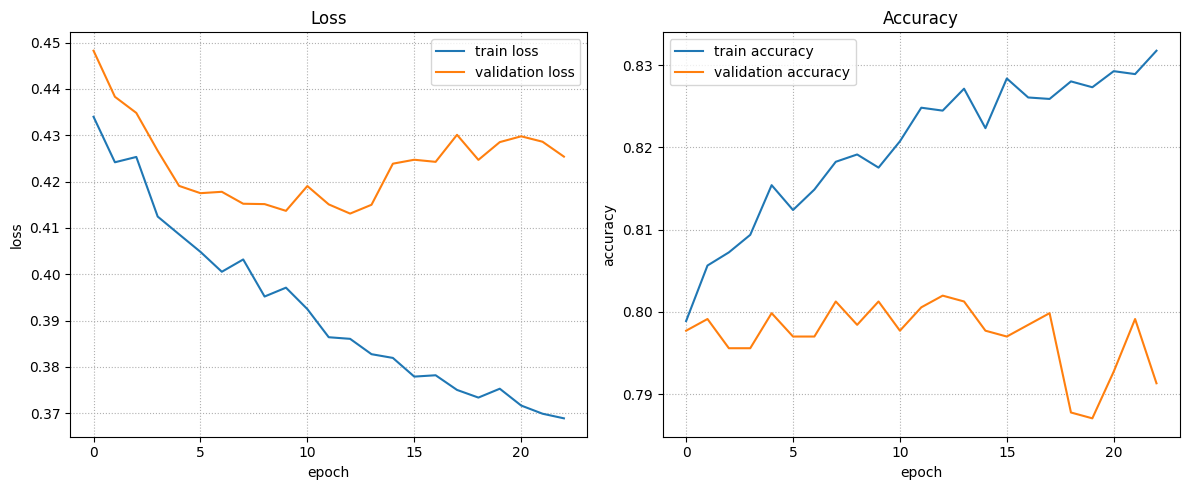

In [27]:
from module.utils import plot_fit_result

plot_fit_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

In [32]:
# BatchNormalize

epochs = 1000
lr = 0.001

class BatchNormModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Linear(40, 64),  
            nn.BatchNorm1d(64),
            nn.ReLU()) 
        self.b2 = nn.Sequential(nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(32, 16),  nn.BatchNorm1d(16), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(16, 8),   nn.BatchNorm1d(8), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(8, 4),   nn.BatchNorm1d(4), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(4, 1))
        self.logistic = nn.Sigmoid() 

    
    def forward(self, X):
        X = nn.Flatten()(X)
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        output = self.logistic(X)
        return output

bn_model = BatchNormModel().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(bn_model.parameters(), lr=lr)
from module.train import fit

train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, test_loader,  
    bn_model, loss_fn, optimizer,
    epochs,
    patience=10,
    device=device,
    mode="binary"
)

Epoch[1/1000] - Train loss: 0.54629 Train Accucracy: 0.73429 || Validation Loss: 0.57235 Validation Accuracy: 0.73456 F1 Score: 0.00399
Epoch[2/1000] - Train loss: 0.50536 Train Accucracy: 0.73465 || Validation Loss: 0.53990 Validation Accuracy: 0.73456 F1 Score: 0.00134
Epoch[3/1000] - Train loss: 0.48324 Train Accucracy: 0.73447 || Validation Loss: 0.52483 Validation Accuracy: 0.73456 F1 Score: 0.00000
Epoch[4/1000] - Train loss: 0.46280 Train Accucracy: 0.73571 || Validation Loss: 0.50870 Validation Accuracy: 0.73314 F1 Score: 0.00664
Epoch[5/1000] - Train loss: 0.43459 Train Accucracy: 0.79215 || Validation Loss: 0.48807 Validation Accuracy: 0.77999 F1 Score: 0.25732
Epoch[6/1000] - Train loss: 0.41755 Train Accucracy: 0.79872 || Validation Loss: 0.46816 Validation Accuracy: 0.78992 F1 Score: 0.46063
Epoch[7/1000] - Train loss: 0.40883 Train Accucracy: 0.80369 || Validation Loss: 0.45464 Validation Accuracy: 0.79205 F1 Score: 0.51528
Epoch[8/1000] - Train loss: 0.39534 Train Accucr

In [31]:
# Dropout

class DropoutModel(nn.Module):

    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.b1 = nn.Sequential(nn.Linear(40, 64), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b2 = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b3 = nn.Sequential(nn.Linear(32, 16), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b4 = nn.Linear(16, 1)
        self.logistic = torch.sigmoid
    
    def forward(self, X):
        X = nn.Flatten()(X)
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        output = self.logistic(X)
        return output    

epochs = 1000
lr = 0.001
dout_model = DropoutModel().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(dout_model.parameters(), lr=lr)
from module.train import fit

train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, test_loader,  
    dout_model, loss_fn, optimizer,
    epochs,
    patience=10,
    device=device,
    mode="binary"
)

Epoch[1/1000] - Train loss: 0.55092 Train Accucracy: 0.73447 || Validation Loss: 0.57732 Validation Accuracy: 0.73456 F1 Score: 0.02882
Epoch[2/1000] - Train loss: 0.45784 Train Accucracy: 0.73429 || Validation Loss: 0.48303 Validation Accuracy: 0.73456 F1 Score: 0.00134
Epoch[3/1000] - Train loss: 0.44109 Train Accucracy: 0.75311 || Validation Loss: 0.46346 Validation Accuracy: 0.75444 F1 Score: 0.17869
Epoch[4/1000] - Train loss: 0.43110 Train Accucracy: 0.79801 || Validation Loss: 0.44744 Validation Accuracy: 0.79418 F1 Score: 0.38447
Epoch[5/1000] - Train loss: 0.42473 Train Accucracy: 0.79996 || Validation Loss: 0.43499 Validation Accuracy: 0.79418 F1 Score: 0.47867
Epoch[6/1000] - Train loss: 0.42045 Train Accucracy: 0.80280 || Validation Loss: 0.43187 Validation Accuracy: 0.79773 F1 Score: 0.51669
Epoch[7/1000] - Train loss: 0.41752 Train Accucracy: 0.80280 || Validation Loss: 0.42478 Validation Accuracy: 0.79702 F1 Score: 0.51006
Epoch[8/1000] - Train loss: 0.41704 Train Accucr

In [14]:
# 모델 구조를 먼저 정의한 후
model = SmallModel()  # 모델의 구조를 정의합니다.
model.load_state_dict(torch.load("best_model.pth"))  # 저장된 모델 가중치를 불러옵니다.
model.to(device)  # GPU나 CPU로 이동
model.eval()  # 모델을 평가 모드로 설정
import torch
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, dataloader, loss_fn, device="cpu"):
    """
    모델을 평가하고 Confusion Matrix 및 Classification Report를 생성하는 함수

    [Parameters]
        model: nn.Module - 평가할 모델
        dataloader: DataLoader - 평가할 데이터셋의 DataLoader
        loss_fn: 손실 함수
        device: str - 연산을 처리할 장치 (default: "cpu")

    [Returns]
        tuple: (평균 손실, 정확도, Confusion Matrix, Classification Report)
    """
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    total_loss = 0.0
    num_batches = len(dataloader)
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()
            
            # 이진 분류일 경우 0.5 기준으로 클래스 분류
            pred_labels = (outputs >= 0.5).type(torch.int)
            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    # 평균 손실 계산
    avg_loss = float(total_loss / num_batches)
    accuracy = float(sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels))  # 정확도를 스칼라 값으로 계산
    
    # Confusion Matrix와 Classification Report 생성
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])
    
    # Confusion Matrix와 Classification Report 출력
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)
    print(f"\nAverage Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return avg_loss, accuracy, cm, report

# 모델 불러오기
model = SmallModel()  # 모델 구조를 다시 정의
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.to(device)

# 손실 함수 정의 (예: 이진 교차 엔트로피)
loss_fn = torch.nn.BCELoss()

# 모델 평가
test_loss, test_accuracy, cm, report = evaluate_model(
    model=model,
    dataloader=test_loader,
    loss_fn=loss_fn,
    device=device
)

Confusion Matrix:
 [[822 213]
 [106 268]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.89      0.79      0.84      1035
     Class 1       0.56      0.72      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409


Average Loss: 0.4452, Accuracy: 0.7736


C:\Users\sang\AppData\Local\Temp\ipykernel_46852\2300235211.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))  # 저장된 모델